# Image classification

### Idea: to take ready-to-use neural network Xception (or another one) from ImageNet and improve it . 

In [1]:
!nvidia-smi

Fri Sep 17 08:39:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Additional installations for Augmentor
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-79ek7sdp
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-79ek7sdp
  Resolved https://github.com/mjkvaak/ImageDataAugmentor to commit eab095f24e5344c9c7b285f3f6c2fef70718de51
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=29576 sha256=c13453f887e86dee01d7f8d937e67e15b4fab2373089ebc7a10c3d305e34ad00
  Stored in directory: /tmp/pip-ephem-wheel-cache-cq2f2aaa/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os

import tensorflow as tf


from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.efficientnet import EfficientNetB5 # for efficientNet attempt
import tensorflow.keras.models as Model
import tensorflow.keras.layers as Layer

from sklearn.model_selection import train_test_split, StratifiedKFold

# Augmentation
import albumentations as a
from ImageDataAugmentor.image_data_augmentor import *

# Visualization
import PIL
from PIL import ImageOps, ImageFilter
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

2021-09-17 08:39:46.556803: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


['train.zip', 'sample-submission.csv', 'test.zip', 'train.csv']
Python       : 3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
Numpy        : 1.19.5
Tensorflow   : 2.4.1
Keras        : 2.4.0


# !pip freeze > requirements.txt

# SETUP

In [4]:
# Main setup

EPOCHS               = 8
BATCH_SIZE           = 32
LR                   = 1e-4
VAL_SPLIT            = 0.15 #test size

CLASS_NUM            = 10  # number of classes
IMG_SIZE             = 224 # image size
IMG_CHANNELS         = 3   # RGB has 3 channels
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../input/'
PATH = "../working/car/" #DIR

In [5]:
# Set random seed 
os.makedirs(PATH,exist_ok=True)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# EDA / Data Analysis

In [6]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [8]:
train_df.Category.value_counts()
# distribution is even enough

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

In [9]:
print('Unpack pictures')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile("../input/"+data_zip,"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Unpack pictures
['test_upload', 'train']


Examples (random sample)


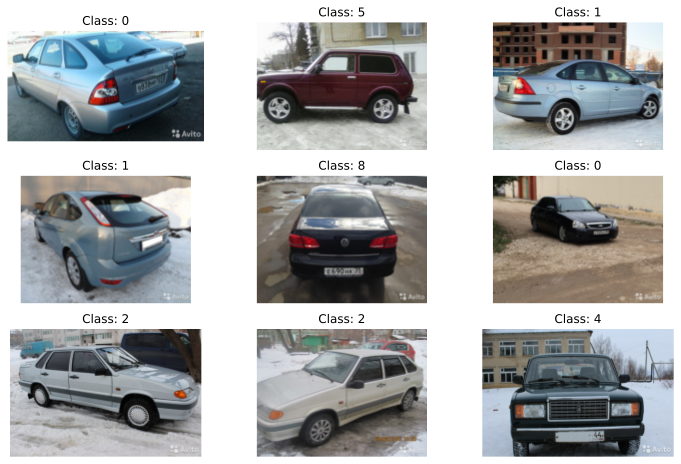

In [10]:
print('Examples (random sample)')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

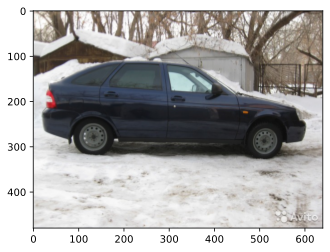

(640, 480)

In [11]:
image = PIL.Image.open(PATH+'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

# Data preparation

### Data augmentation with Albumentations 

In [12]:
# Documentation: https://github.com/albu/albumentations

augmentations = a.Compose([
    a.GaussianBlur(p=0.05), # add Gauss bluring and noise with 5% probability
    a.GaussNoise(p=0.05),
    a.ShiftScaleRotate(shift_limit=0.0625, 
                       scale_limit=0.01, 
                       interpolation=1, 
                       border_mode=4, 
                       rotate_limit=20, 
                       p=.75), # shift, scale, rotate with higher than default probablity can be useful for variety 
#     in our images 
    a.RandomBrightness(limit=0.2, p=0.5),
    
#     Add some more aumentations with default parameters
    
    a.HorizontalFlip(), # as we take a look on car's model it may vary with different mirroring,
                        # then to get better result we can turn it on NO VERTICAL FLIP because cars are always in horizontal
    a.HueSaturationValue(), # random hue and saturation
    a.RGBShift(),
    a.FancyPCA(alpha=0.1, 
               always_apply=False, 
               p=0.5),
    a.Resize(IMG_SIZE, IMG_SIZE),
    
    #  add OneOfs with default 50% probability for brightness contrast
    a.OneOf([
        a.RandomBrightnessContrast(brightness_limit=0.3, 
                                                contrast_limit=0.3),
        a.RandomBrightnessContrast(brightness_limit=0.1, 
                                                contrast_limit=0.1)],
        p=0.5)
])


/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1746: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


### Data generation

In [13]:
# Common datagen for train and test based on Augmentor

datagen = ImageDataAugmentor(
#                         rescale=1./255,
                        augment=augmentations, 
                        seed=RANDOM_SEED,
                        validation_split=VAL_SPLIT)

In [14]:
# Wrap our data into generator:

train_datagen = datagen.flow_from_directory(
    PATH+'train/',      # DIR
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    subset='training') # set as training data

test_datagen = datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='validation') # set as validation data

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.


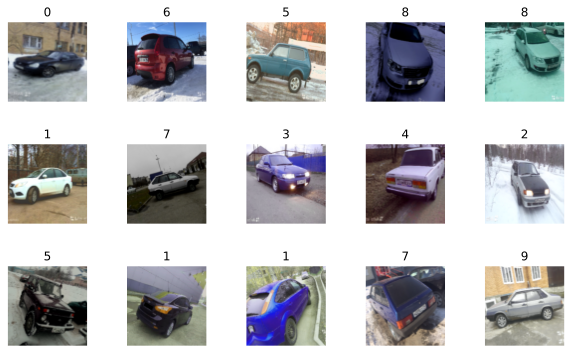

In [15]:
# Let's take a look on augmented cars images
train_datagen.show_data(rows=3, cols=5)

# Build the model

### Download Xception/EfficientNetB5:

In [16]:
# Here we choose one of 2 models to compare
# base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)
base_model = EfficientNetB5(weights='imagenet', include_top=False, input_shape = input_shape)

2021-09-17 08:40:19.180717: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-17 08:40:19.187252: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-17 08:40:19.244584: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-17 08:40:19.245270: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-17 08:40:19.245360: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-17 08:40:19.275585: I tensorflow/stream_executor/platform/def

115269632/115263384 [==============================] - 1s 0us/step


In [17]:
# base_model.summary()

In [18]:
# freeze the pre-trained model weights, train only the top layers
base_model.trainable = False

In [19]:
model = Model.Sequential()
model.add(base_model)

In [20]:
# Set new head

# Add pooling layer
model.add(Layer.GlobalAveragePooling2D())

# Add a fully-connected layer
model.add(Layer.Dense(256, 
                      activation='relu', 
                      bias_regularizer=l2(1e-4),
                      activity_regularizer=l2(1e-5)))

# Add batch normalization
model.add(Layer.BatchNormalization())
model.add(Layer.Dropout(0.25)) # and dropout
# model.add(Layer.BatchNormalization())
# model.add(Layer.Dropout(0.25))

# And a final layer for 10 classes
model.add(Layer.Dense(CLASS_NUM, activation='softmax'))

# This is the model we will train
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb5 (Functional)  (None, 7, 7, 2048)        28513527  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 29,041,665
Trainable params: 527,626
Non-trainable params: 28,514,039
______________________________________

In [22]:
# Check the trainable status of the individual layers (should be False for base model and True for head)
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.functional.Functional object at 0x7ff1f9f11450> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7ff1c06b5b90> True
<tensorflow.python.keras.layers.core.Dense object at 0x7ff1c356fa50> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7ff1c06c11d0> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7ff1c06b2c50> True
<tensorflow.python.keras.layers.core.Dense object at 0x7ff1c06d3810> True


## Train model

In [23]:
# Add checkpoint function to save best model
checkpoint = ModelCheckpoint('best_model.hdf5', 
                             monitor = ['val_accuracy'], 
                             verbose = 1,
                             mode = 'max')

# Add LR scheduler (decrease rate exponentialy after 4 epoch)
# ARTICLE APPLIED: https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6
lr_scheduler = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2, #let's reduce LR 5 times
                              patience=2, # if no improvement after 2 epoch - reduce LR
                              min_lr=0.0000001,
                              verbose=1,
                              mode='auto')

# Add early stop
earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = 4,
                          restore_best_weights = True)

callbacks_list = [checkpoint, earlystop, lr_scheduler]

In [24]:
history = model.fit(
        train_datagen,
        steps_per_epoch = len(train_datagen),
        validation_data = test_datagen, 
        validation_steps = len(test_datagen),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

2021-09-17 08:40:29.332638: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-17 08:40:29.335897: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000179999 Hz


Epoch 1/8


2021-09-17 08:40:42.359777: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-17 08:40:43.323354: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-09-17 08:40:43.365384: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


414/414 [==============================] - 183s 396ms/step - loss: 2.1635 - accuracy: 0.3114 - val_loss: 1.1700 - val_accuracy: 0.5887

Epoch 00001: saving model to best_model.hdf5
Epoch 2/8
414/414 [==============================] - 159s 385ms/step - loss: 1.3269 - accuracy: 0.5404 - val_loss: 0.9845 - val_accuracy: 0.6604

Epoch 00002: saving model to best_model.hdf5
Epoch 3/8
414/414 [==============================] - 158s 381ms/step - loss: 1.1295 - accuracy: 0.6035 - val_loss: 0.8903 - val_accuracy: 0.6956

Epoch 00003: saving model to best_model.hdf5
Epoch 4/8
414/414 [==============================] - 157s 380ms/step - loss: 1.0320 - accuracy: 0.6410 - val_loss: 0.8565 - val_accuracy: 0.7055

Epoch 00004: saving model to best_model.hdf5
Epoch 5/8
414/414 [==============================] - 158s 382ms/step - loss: 0.9533 - accuracy: 0.6669 - val_loss: 0.8099 - val_accuracy: 0.7222

Epoch 00005: saving model to best_model.hdf5
Epoch 6/8
414/414 [==============================] - 15

In [25]:
# Save the model and upload best_model
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [26]:
scores = model.evaluate(test_datagen, steps=len(test_datagen), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

73/73 [==============================] - 24s 327ms/step - loss: 0.7318 - accuracy: 0.7471
Accuracy: 74.71%


In [27]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


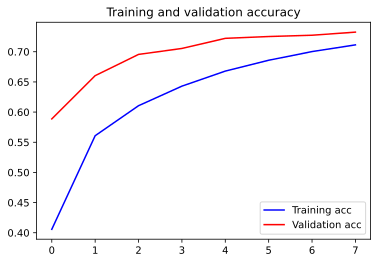

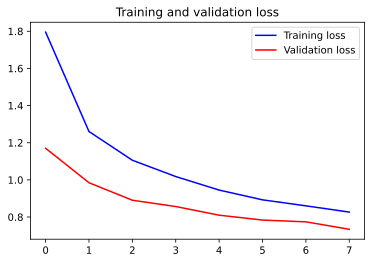

In [28]:
plot_history(history)

### We got a good result but could be better, accuracy is still low, let's try to apply fine tuning and unfreeze some layers.

# Fine-tuning

### Unfreeze 50% of layers in base model

In [29]:
base_model.trainable = True

# Fine-tune starting point
start_point = len(base_model.layers)//2

# Keep all other layers frozen
for layer in base_model.layers[:start_point]:
    layer.trainable =  False

In [30]:
# Compile new model
model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(lr=LR), 
              metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb5 (Functional)  (None, 7, 7, 2048)        28513527  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 29,041,665
Trainable params: 26,875,402
Non-trainable params: 2,166,263
____________________________________

In [31]:
# Check the trainable status
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.functional.Functional object at 0x7ff1f9f11450> True
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7ff1c06b5b90> True
<tensorflow.python.keras.layers.core.Dense object at 0x7ff1c356fa50> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7ff1c06c11d0> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7ff1c06b2c50> True
<tensorflow.python.keras.layers.core.Dense object at 0x7ff1c06d3810> True


In [32]:
# Fit again
history = model.fit(
        train_datagen,
        steps_per_epoch = len(train_datagen),
        validation_data = test_datagen, 
        validation_steps = len(test_datagen),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/8
414/414 [==============================] - 201s 445ms/step - loss: 1.3716 - accuracy: 0.5491 - val_loss: 0.4456 - val_accuracy: 0.8381

Epoch 00001: saving model to best_model.hdf5
Epoch 2/8
414/414 [==============================] - 181s 436ms/step - loss: 0.4028 - accuracy: 0.8551 - val_loss: 0.2888 - val_accuracy: 0.8974

Epoch 00002: saving model to best_model.hdf5
Epoch 3/8
414/414 [==============================] - 181s 436ms/step - loss: 0.2631 - accuracy: 0.9085 - val_loss: 0.2553 - val_accuracy: 0.9163

Epoch 00003: saving model to best_model.hdf5
Epoch 4/8
414/414 [==============================] - 182s 440ms/step - loss: 0.2017 - accuracy: 0.9268 - val_loss: 0.2081 - val_accuracy: 0.9309

Epoch 00004: saving model to best_model.hdf5
Epoch 5/8
414/414 [==============================] - 183s 442ms/step - loss: 0.1420 - accuracy: 0.9483 - val_loss: 0.2113 - val_accuracy: 0.9227

Epoch 00005: saving model to best_model.hdf5
Epoch 6/8
414/414 [==========================

In [33]:
model.load_weights('best_model.hdf5') 

In [34]:
scores = model.evaluate(test_datagen, steps=len(test_datagen), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

73/73 [==============================] - 23s 319ms/step - loss: 0.2024 - accuracy: 0.9330
Accuracy: 93.30%


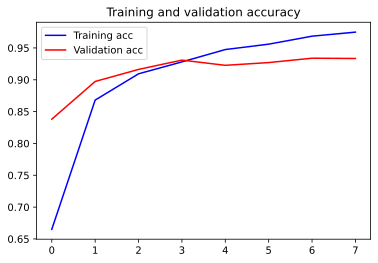

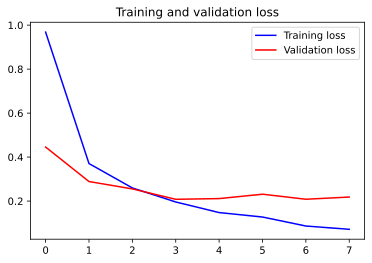

In [35]:
plot_history(history)

### Unfreeze 100% of layers in base model

In [36]:
base_model.trainable = True

In [37]:
# Compile new model
model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(lr=LR), 
              metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb5 (Functional)  (None, 7, 7, 2048)        28513527  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 29,041,665
Trainable params: 28,868,410
Non-trainable params: 173,255
______________________________________

In [38]:
# Check the trainable status
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.functional.Functional object at 0x7ff1f9f11450> True
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7ff1c06b5b90> True
<tensorflow.python.keras.layers.core.Dense object at 0x7ff1c356fa50> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7ff1c06c11d0> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7ff1c06b2c50> True
<tensorflow.python.keras.layers.core.Dense object at 0x7ff1c06d3810> True


In [39]:
# Fit again
history = model.fit(
        train_datagen,
        steps_per_epoch = len(train_datagen),
        validation_data = test_datagen, 
        validation_steps = len(test_datagen),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/8
414/414 [==============================] - 339s 769ms/step - loss: 0.1325 - accuracy: 0.9558 - val_loss: 0.2285 - val_accuracy: 0.9270

Epoch 00001: saving model to best_model.hdf5
Epoch 2/8
414/414 [==============================] - 314s 758ms/step - loss: 0.0993 - accuracy: 0.9653 - val_loss: 0.2308 - val_accuracy: 0.9322

Epoch 00002: saving model to best_model.hdf5
Epoch 3/8
414/414 [==============================] - 314s 758ms/step - loss: 0.0827 - accuracy: 0.9714 - val_loss: 0.2274 - val_accuracy: 0.9300

Epoch 00003: saving model to best_model.hdf5
Epoch 4/8
414/414 [==============================] - 315s 760ms/step - loss: 0.0699 - accuracy: 0.9777 - val_loss: 0.2051 - val_accuracy: 0.9407

Epoch 00004: saving model to best_model.hdf5
Epoch 5/8
414/414 [==============================] - 315s 761ms/step - loss: 0.0603 - accuracy: 0.9790 - val_loss: 0.2048 - val_accuracy: 0.9480

Epoch 00005: saving model to best_model.hdf5
Epoch 6/8
414/414 [==========================

In [40]:
model.load_weights('best_model.hdf5') 
scores = model.evaluate(test_datagen, steps=len(test_datagen), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

73/73 [==============================] - 24s 326ms/step - loss: 0.2105 - accuracy: 0.9433
Accuracy: 94.33%


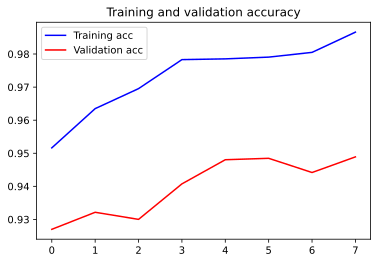

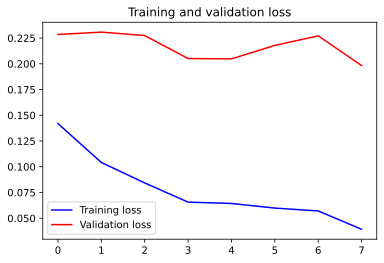

In [41]:
plot_history(history)

In [42]:
# Save as last model
model.save('../working/model_last.hdf5')

# Predictions

In [43]:
test_gen = ImageDataAugmentor() # rescale=1./255 
test_sub_generator = test_gen.flow_from_dataframe(dataframe=sample_submission,
                                            directory=PATH+'test_upload/',
                                            x_col="Id",
                                            y_col=None,
                                            shuffle=False,
                                            class_mode=None,
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            batch_size=BATCH_SIZE)

Found 6675 validated image filenames.


In [44]:
test_sub_generator.reset()
predictions = model.predict(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) # multiple categories
label_map = (train_datagen.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

209/209 [==============================] - 49s 220ms/step


In [45]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, 
                          columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')

submission.to_csv('submission.csv', index=False)

In [46]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,9
4,87877.jpg,7


### Got 95,5% on submission, let's try to improve

# Improvements

## Change Image and Batch size

In [47]:
EPOCHS               = 7 # keep 7 because at epoch 8 we had slight overfitting
BATCH_SIZE           = 8
LR                   = 1e-4 # start with this LR 
VAL_SPLIT            = 0.15 #test size

CLASS_NUM            = 10  # number of classes
IMG_SIZE             = 512 # image size
IMG_CHANNELS         = 3   # RGB has 3 channels
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [48]:
train_datagen = datagen.flow_from_directory(
    PATH+'train/',      # DIR
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    subset='training') # set as training data

test_datagen = datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='validation') # set as validation data

test_sub_generator = test_gen.flow_from_dataframe(dataframe=sample_submission,
                                            directory=PATH+'test_upload/',
                                            x_col="Id",
                                            y_col=None,
                                            shuffle=False,
                                            class_mode=None,
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            batch_size=BATCH_SIZE)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


In [49]:
# Keep last model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb5 (Functional)  (None, 7, 7, 2048)        28513527  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 29,041,665
Trainable params: 28,868,410
Non-trainable params: 173,255
______________________________________

In [50]:
# Check the trainable status
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.functional.Functional object at 0x7ff1f9f11450> True
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7ff1c06b5b90> True
<tensorflow.python.keras.layers.core.Dense object at 0x7ff1c356fa50> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7ff1c06c11d0> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7ff1c06b2c50> True
<tensorflow.python.keras.layers.core.Dense object at 0x7ff1c06d3810> True


In [51]:
# Fit again
history = model.fit(
        train_datagen,
        steps_per_epoch = len(train_datagen),
        validation_data = test_datagen, 
        validation_steps = len(test_datagen),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/7
1654/1654 [==============================] - 559s 338ms/step - loss: 0.1133 - accuracy: 0.9641 - val_loss: 0.2077 - val_accuracy: 0.9502

Epoch 00001: saving model to best_model.hdf5
Epoch 2/7
1654/1654 [==============================] - 570s 345ms/step - loss: 0.0880 - accuracy: 0.9718 - val_loss: 0.2142 - val_accuracy: 0.9485

Epoch 00002: saving model to best_model.hdf5
Epoch 3/7
1654/1654 [==============================] - 554s 335ms/step - loss: 0.0797 - accuracy: 0.9750 - val_loss: 0.1934 - val_accuracy: 0.9476

Epoch 00003: saving model to best_model.hdf5
Epoch 4/7
1654/1654 [==============================] - 549s 332ms/step - loss: 0.0671 - accuracy: 0.9783 - val_loss: 0.2067 - val_accuracy: 0.9553

Epoch 00004: saving model to best_model.hdf5
Epoch 5/7
1654/1654 [==============================] - 555s 335ms/step - loss: 0.0631 - accuracy: 0.9810 - val_loss: 0.2173 - val_accuracy: 0.9532

Epoch 00005: saving model to best_model.hdf5

Epoch 00005: ReduceLROnPlateau red

In [52]:
# Accuracy
model.load_weights('best_model.hdf5') 
scores = model.evaluate(test_datagen, steps=len(test_datagen), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

292/292 [==============================] - 63s 214ms/step - loss: 0.2172 - accuracy: 0.9528
Accuracy: 95.28%


In [53]:
# Save as last model
model.save('../working/model_last.hdf5')

In [54]:
# PREDICTIONS
test_sub_generator.reset()
predictions = model.predict(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) # multiple categories
label_map = (train_datagen.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, 
                          columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')

submission.to_csv('submission_size_batch.csv', index=False)

835/835 [==============================] - 134s 160ms/step


## Test Time Augmentation 
#### https://towardsdatascience.com/test-time-augmentation-tta-and-how-to-perform-it-with-keras-4ac19b67fb4d

In [55]:
#  Add augmentation to validation set
test_gen = ImageDataAugmentor(
#                         rescale=1./255,
                        augment=augmentations, 
                        seed=RANDOM_SEED,
                        validation_split=VAL_SPLIT
                       )

test_sub_generator = test_gen.flow_from_dataframe(dataframe=sample_submission,
                                            directory=PATH+'test_upload/',
                                            x_col="Id",
                                            y_col=None,
                                            shuffle=False,
                                            class_mode=None,
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            batch_size=BATCH_SIZE)

Found 6675 validated image filenames.


In [56]:
STEPS = 5
predictions = []

for i in range(STEPS):
    x = model.predict(test_sub_generator, verbose=1) 
    predictions.append(x)

avg_prediction = np.mean(predictions, axis=0) # take average from predictions we have

835/835 [==============================] - 183s 219ms/step


In [57]:
predictions = np.argmax(avg_prediction, axis=-1) # multiple categories
label_map = (train_datagen.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, 
                          columns=['Id', 'Category'])

submission['Id'] = submission['Id'].replace('test_upload/','')

In [58]:
# Check current accuracy
scores = model.evaluate(test_datagen, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

292/292 [==============================] - 64s 219ms/step - loss: 0.1952 - accuracy: 0.9575
Accuracy: 95.75%


In [59]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,7
4,87877.jpg,9


In [60]:
# Save submission
submission.to_csv('submission_tta.csv', index=False)

#### Clean working path

In [61]:
# Clean PATH
# import shutil
# shutil.rmtree(PATH)

# Conclusion

#### The best model is based on EfficientNetB5 with:
     100% unfrozen layers 
     8 as batch size
     7 epochs
     512px as Img size
     
   Got **95.75%** accuracy and **96.42%** on kaggle submission
 
 #### Techniques and functions used for the project:
* Transfer learning with fine-tuning 
* 2 base models: Xception and EfficientNetB5
* Batch Normalization added and callbacks 
* Advanced Albumentations package for augmentation
* Leraning rate managing techique
* Test Time Augmentation (just tested)